In [5]:
import os
import numpy as np
import pandas as pd

import nltk
from nltk import corpus, tokenize
from nltk.corpus import stopwords

import re

from nltk.stem import porter,PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [6]:
hotstar= pd.read_csv('hotstar_reviews.csv')
hotstar.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,08-10-2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,08-11-2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,08-12-2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,08-11-2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,08-05-2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [7]:
hotstar.shape

(5053, 13)

In [8]:
hotstar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   5053 non-null   int64 
 1   UserName             4331 non-null   object
 2   Created_Date         5053 non-null   object
 3   Reviews              5053 non-null   object
 4   Lower_Case_Reviews   5053 non-null   object
 5   Sentiment_Manual_BP  5053 non-null   object
 6   Sentiment_Manual     5053 non-null   object
 7   Review_Length        5053 non-null   int64 
 8   DataSource           5053 non-null   object
 9   Year                 5053 non-null   int64 
 10  Month                5053 non-null   int64 
 11  Date                 5053 non-null   int64 
 12  Sentiment_Polarity   5053 non-null   object
dtypes: int64(5), object(8)
memory usage: 513.3+ KB


In [9]:
hotstar.Sentiment_Manual.value_counts()

Sentiment_Manual
Neutral     1738
Positive    1733
Negative    1582
Name: count, dtype: int64

In [10]:
hotstar.Sentiment_Manual.value_counts()/hotstar.Sentiment_Manual.size*100

Sentiment_Manual
Neutral     34.395409
Positive    34.296458
Negative    31.308134
Name: count, dtype: float64

In [11]:
hotstar.DataSource.value_counts()/hotstar.DataSource.size*100

DataSource
Twitter             55.927172
Google_PlayStore    44.072828
Name: count, dtype: float64

In [12]:
pd.pivot_table(hotstar, index='Sentiment_Manual', columns='DataSource',
              values='ID', aggfunc='count')/hotstar.DataSource.size*100

DataSource,Google_PlayStore,Twitter
Sentiment_Manual,,
Negative,12.923016,18.385118
Neutral,5.125668,29.269741
Positive,26.024144,8.272313


In [13]:
hotstar.columns

Index(['ID', 'UserName', 'Created_Date', 'Reviews', 'Lower_Case_Reviews',
       'Sentiment_Manual_BP', 'Sentiment_Manual', 'Review_Length',
       'DataSource', 'Year', 'Month', 'Date', 'Sentiment_Polarity'],
      dtype='object')

In [14]:
review_data=hotstar[['Lower_Case_Reviews','DataSource','Sentiment_Manual']]

review_data.head()

,Lower_Case_Reviews,DataSource,Sentiment_Manual
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [15]:
review_data.columns=['Reviews','Source','Sentiment']

In [16]:
review_data.head()

,Reviews,Source,Sentiment
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [17]:
review_data.describe(include='object')

,Reviews,Source,Sentiment
count,5053,5053,5053
unique,5053,2,3
top,hh,Twitter,Neutral
freq,1,2826,1738


In [18]:
review_data['Source']=review_data['Source'].astype('category')
review_data['Source']=review_data['Source'].cat.codes
review_data['Source'].value_counts()

Source
1    2826
0    2227
Name: count, dtype: int64

In [19]:
punctuation = list(string.punctuation)
stop_words = stopwords.words('english')

re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\d]+[a-zA-Z_+='?]+[\d]+[\d]+|[a-zA-Z_*+=]+[\d]+[a-zA-Z_*+-=]+|[\d]+"""

re_patter= re_pattern + """|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt"""

reviewText = [re.sub(pattern=re_patter,string=text,repl=" ")
            for text in review_data.Reviews.map(str).values]

In [20]:
re_pattern

'@[a-zA-Z0-9_:]+|b[\'"]rt|[\\d]+[a-zA-Z_+=\'?]+[\\d]+[\\d]+|[a-zA-Z_*+=]+[\\d]+[a-zA-Z_*+-=]+|[\\d]+'

In [21]:
print(reviewText[2])

  during paymnt for premium subscription the transaction failed twice but i have not received refund for one of the transaction


In [22]:
review_data_cleaned=[]

for review in reviewText:
    stop_free= " ".join([txt for txt in review.lower().split() if txt not in stop_words]) # stop_words--NLTK
    stop_free_1= " ".join([txt for txt in stop_free.lower().split() if txt not in STOPWORDS])#STOPWORDS--Wordcloud
    punct_free= " ".join([txt for txt in stop_free_1.lower().split() if txt not in punctuation])
    review_data_cleaned.append(punct_free)

In [23]:
review_data_cleaned[7]

'today epi #lovekahaiintezaar nt available available morning showing nt available due expiry'

In [24]:
# Remove Hashtag
review_data_cleaned_final=[]
for rdfc in review_data_cleaned:
    final_words=rdfc.replace('#','')
    review_data_cleaned_final.append(final_words)

In [25]:
review_data_cleaned_final[7]

'today epi lovekahaiintezaar nt available available morning showing nt available due expiry'

In [26]:
#Remove Hashtag- other method

# corpus=[]
# for i in range(len(review_data_cleaned)):
#     review= re.sub('[^a-zA-Z]',' ',review_data_cleaned[i])
#     review=''.join(review)
#     corpus.append(review)

In [27]:
# Lemmatization
wd=WordNetLemmatizer()

review_data_cleaned_final_output = []
for rdc in review_data_cleaned_final:
    clean_review= " ".join(wd.lemmatize(word) for word in rdc.split())
    review_data_cleaned_final_output.append(clean_review)

In [28]:
review_data_cleaned_final_output

['hh',
 '',
 'paymnt premium subscription transaction failed twice received refund one transaction',
 'currently jio network know whether able watch epl telecasted star spo select hd',
 'episode sarabhai v sarabhai season downloadable able watch offline please smthng',
 'able watch latest episode got app allow take screenshot error help resolve asap',
 'please allow rupay maestro payment gateway premium membership mean paytm work thru debit card great',
 'today epi lovekahaiintezaar nt available available morning showing nt available due expiry',
 'hotstarfraud paid subscription july havent received cashback specified hdfc card',
 'premium accnt hotstar showing tht premium member u pls chk',
 'seeing blank page term amp condition hdfc bank cashback offer hotstar premium membership please help',
 'sir please allow u download video ur app present option allow u dwnld mre video due ltd space',
 'hi pl tab spo homepage isl bundesliga search team name stream pls look',
 'unable watch star s

In [29]:
review_data['clean_review']=review_data_cleaned_final_output

In [30]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [31]:
X_train, X_test, y_train, y_test=train_test_split(review_data['clean_review'],
                                                 review_data['Sentiment'],
                                                 test_size=0.2,
                                                 random_state=17,
                                                 stratify=review_data['Sentiment'])

In [32]:
# Feature Extraction- Bag of Words
# Vectorize the text usinf count vectorizer

vectorizer=CountVectorizer().fit(X_train)
X_train_vectorized=vectorizer.transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

In [33]:
X_train

2907                                          outstanding
972           pay hotstar subscription stream quality bad
1853    watch originalisspyarkokyanaamdoon nosarunnoip...
4696    good app high speed work run fast internet fas...
607     want watch hotstar u need fucking indian vpn t...
                              ...                        
724     well well well leak game throne really concern...
1065                       hotstar love god stop stopping
3861                                  hotstar big app spo
2488                                              pollich
1605                          show ipl pak player hotstar
Name: clean_review, Length: 4042, dtype: object

In [34]:
X_train_vectorized

<4042x4958 sparse matrix of type '<class 'numpy.int64'>'
	with 24901 stored elements in Compressed Sparse Row format>

In [35]:
print(vectorizer.get_feature_names_out())

['aa' 'aaaaaand' 'aab' ... 'zinab' 'zindabad' 'zombie']


In [36]:
pd.DataFrame(X_train_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4948,4949,4950,4951,4952,4953,4954,4955,4956,4957
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
pd.DataFrame(X_test_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4948,4949,4950,4951,4952,4953,4954,4955,4956,4957
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
naive_bays_multi= MultinomialNB().fit(X_train_vectorized,y_train)


In [39]:
print(naive_bays_multi.score(X_train_vectorized,y_train))
print()
print(naive_bays_multi.score(X_test_vectorized,y_test))

0.8807521029193469

0.734915924826904


In [40]:
predict_train= naive_bays_multi.predict(X_train_vectorized)

predict_test= naive_bays_multi.predict(X_test_vectorized)

In [41]:
predict_train

array(['Positive', 'Negative', 'Neutral', ..., 'Negative', 'Positive',
       'Neutral'], dtype='<U8')

In [42]:
predict_test

array(['Negative', 'Negative', 'Neutral', ..., 'Neutral', 'Negative',
       'Negative'], dtype='<U8')

In [43]:
def get_num(data):
    data_new=pd.DataFrame(data,columns=['Sentiment'])
    data_new['y_label']=np.where(data_new['Sentiment']=='Neutral',0,
                                np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [44]:
y_train_new= get_num(y_train)
y_test_new= get_num(y_test)
predict_train_new= get_num(predict_train)
predict_test_new= get_num(predict_test)

In [45]:
predict_test_new

,Sentiment,y_label
0,Negative,2
1,Negative,2
2,Neutral,0
3,Negative,2
4,Neutral,0
...,...,...
1006,Negative,2
1007,Negative,2
1008,Neutral,0
1009,Negative,2


In [46]:
print(classification_report(y_train_new['y_label'],predict_train_new['y_label']))
print()
print(classification_report(y_test_new['y_label'],predict_test_new['y_label']))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1390
           1       0.89      0.91      0.90      1386
           2       0.85      0.92      0.88      1266

    accuracy                           0.88      4042
   macro avg       0.88      0.88      0.88      4042
weighted avg       0.88      0.88      0.88      4042


              precision    recall  f1-score   support

           0       0.75      0.68      0.71       348
           1       0.79      0.72      0.75       347
           2       0.68      0.81      0.74       316

    accuracy                           0.73      1011
   macro avg       0.74      0.74      0.73      1011
weighted avg       0.74      0.73      0.73      1011



In [47]:
print(accuracy_score(y_train_new['y_label'],predict_train_new['y_label']))
print()
print(accuracy_score(y_test_new['y_label'],predict_test_new['y_label']))

0.8807521029193469

0.734915924826904


In [48]:
# Random Forest Classifier

rf_model= RandomForestClassifier().fit(X_train_vectorized,y_train)

In [49]:
print(rf_model.score(X_train_vectorized,y_train))
print()
print(rf_model.score(X_test_vectorized,y_test))

0.9883720930232558

0.7181008902077152


In [50]:
predict_train1= rf_model.predict(X_train_vectorized)

predict_test1= rf_model.predict(X_test_vectorized)

In [51]:
def get_num(data):
    data_new=pd.DataFrame(data,columns=['Sentiment'])
    data_new['y_label']=np.where(data_new['Sentiment']=='Neutral',0,
                                np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [52]:
y_train_new1= get_num(y_train)
y_test_new1= get_num(y_test)
predict_train_new1= get_num(predict_train1)
predict_test_new1= get_num(predict_test1)

In [53]:
print(classification_report(y_train_new1['y_label'],predict_train_new1['y_label']))
print()
print(classification_report(y_test_new1['y_label'],predict_test_new1['y_label']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1390
           1       0.99      0.99      0.99      1386
           2       1.00      0.99      0.99      1266

    accuracy                           0.99      4042
   macro avg       0.99      0.99      0.99      4042
weighted avg       0.99      0.99      0.99      4042


              precision    recall  f1-score   support

           0       0.68      0.72      0.70       348
           1       0.78      0.74      0.76       347
           2       0.69      0.69      0.69       316

    accuracy                           0.72      1011
   macro avg       0.72      0.72      0.72      1011
weighted avg       0.72      0.72      0.72      1011



In [54]:
print(accuracy_score(y_train_new1['y_label'],predict_train_new1['y_label']))
print()
print(accuracy_score(y_test_new1['y_label'],predict_test_new1['y_label']))

0.9883720930232558

0.7181008902077152


# Apply k-fold Method

In [55]:
from sklearn.model_selection import cross_val_score

In [56]:
training_accuracy=cross_val_score(rf_model,X_train_vectorized,y_train,cv=10)
print(training_accuracy.mean())

0.7350317809558733


# XG Boost

In [57]:
def get_num(data):
    data_new=pd.DataFrame(data,columns=['Sentiment'])
    data_new['y_label']=np.where(data_new['Sentiment']=='Neutral',0,
                                np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [58]:
y_train_new2= get_num(y_train)
y_test_new2= get_num(y_test)


In [59]:
xgboost=XGBClassifier().fit(X_train_vectorized,y_train_new2['y_label'])

In [60]:
print(xgboost.score(X_train_vectorized,y_train_new2['y_label']))
print()
print(xgboost.score(X_test_vectorized,y_test_new2['y_label']))

0.8352300841167739

0.7260138476755688


In [61]:
training_accuracy1=cross_val_score(xgboost,X_train_vectorized,y_train_new2['y_label'],cv=10)
print(training_accuracy1.mean())

0.7318090697958685


# Feature extraction using TF-IDF( Term Frequency Inverse document frequency)

In [62]:
tf_idf=TfidfVectorizer().fit(X_train)
X_train_tf_idf=tf_idf.transform(X_train)
X_test_tf_idf=tf_idf.transform(X_test)

In [63]:
pd.DataFrame(X_test_tf_idf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4948,4949,4950,4951,4952,4953,4954,4955,4956,4957
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
xgboost1=XGBClassifier().fit(X_train_tf_idf,y_train_new2['y_label'])

In [65]:
print(xgboost1.score(X_train_tf_idf,y_train_new2['y_label']))
print()
print(xgboost1.score(X_test_tf_idf,y_test_new2['y_label']))

0.8792676892627412

0.7250247279920871


# Analysis by using Word Cloud

In [66]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [67]:
review_data.Sentiment.unique()

array(['Negative', 'Positive', 'Neutral'], dtype=object)

In [68]:
positive_review= review_data[review_data['Sentiment']=='Positive']['clean_review']
negative_review= review_data[review_data['Sentiment']=='Negative']['clean_review']
neutral_review= review_data[review_data['Sentiment']=='Neutral']['clean_review']

In [69]:
neutral_review.shape

(1738,)

In [70]:
pos_data_token=[nltk.word_tokenize(rvw) for rvw in positive_review ]
neg_data_token=[nltk.word_tokenize(rvw) for rvw in negative_review ]
ntrl_data_token=[nltk.word_tokenize(rvw) for rvw in neutral_review ]

In [71]:
neg_data_token

[['hh'],
 [],
 ['paymnt',
  'premium',
  'subscription',
  'transaction',
  'failed',
  'twice',
  'received',
  'refund',
  'one',
  'transaction'],
 ['currently',
  'jio',
  'network',
  'know',
  'whether',
  'able',
  'watch',
  'epl',
  'telecasted',
  'star',
  'spo',
  'select',
  'hd'],
 ['episode',
  'sarabhai',
  'v',
  'sarabhai',
  'season',
  'downloadable',
  'able',
  'watch',
  'offline',
  'please',
  'smthng'],
 ['able',
  'watch',
  'latest',
  'episode',
  'got',
  'app',
  'allow',
  'take',
  'screenshot',
  'error',
  'help',
  'resolve',
  'asap'],
 ['please',
  'allow',
  'rupay',
  'maestro',
  'payment',
  'gateway',
  'premium',
  'membership',
  'mean',
  'paytm',
  'work',
  'thru',
  'debit',
  'card',
  'great'],
 ['today',
  'epi',
  'lovekahaiintezaar',
  'nt',
  'available',
  'available',
  'morning',
  'showing',
  'nt',
  'available',
  'due',
  'expiry'],
 ['hotstarfraud',
  'paid',
  'subscription',
  'july',
  'havent',
  'received',
  'cashback

In [72]:
word_cloud_pos= WordCloud(background_color='green', max_words=200, max_font_size=40,
                         scale=3, random_state=17).generate(str(pos_data_token))

word_cloud_neg= WordCloud(background_color='red', max_words=200, max_font_size=40,
                         scale=3, random_state=17).generate(str(neg_data_token))

word_cloud_ntrl= WordCloud(background_color='orange', max_words=200, max_font_size=40,
                         scale=3, random_state=17).generate(str(ntrl_data_token))

In [73]:
import matplotlib.pyplot as plt

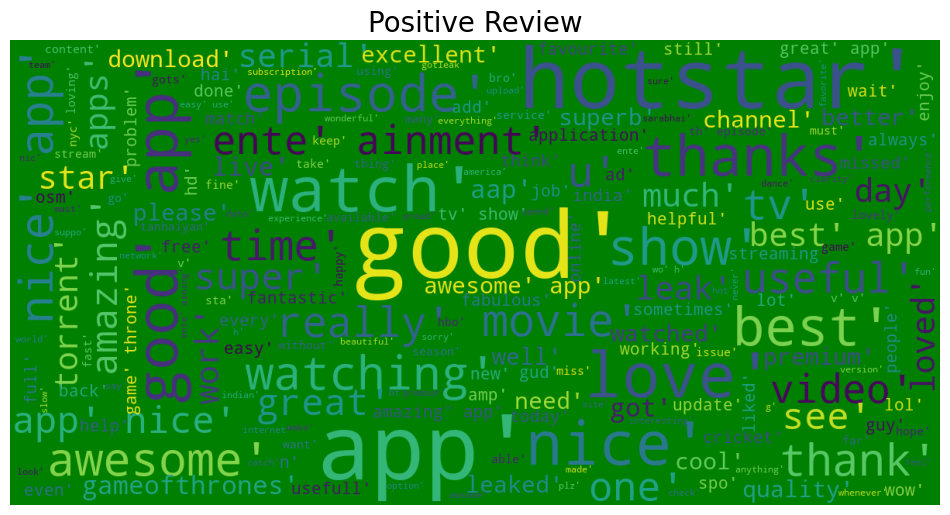

In [74]:
fig= plt.figure(1,figsize=(12,12))
plt.axis('off')
plt.imshow(word_cloud_pos)
plt.title("Positive Review",size=20)
plt.show()

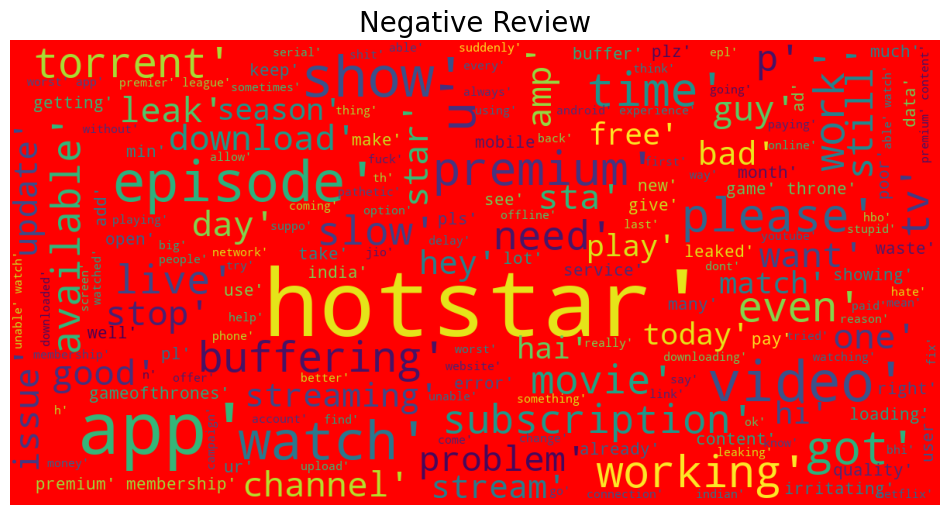

In [75]:
fig= plt.figure(1,figsize=(12,12))
plt.axis('off')
plt.imshow(word_cloud_neg)
plt.title("Negative Review",size=20)
plt.show()

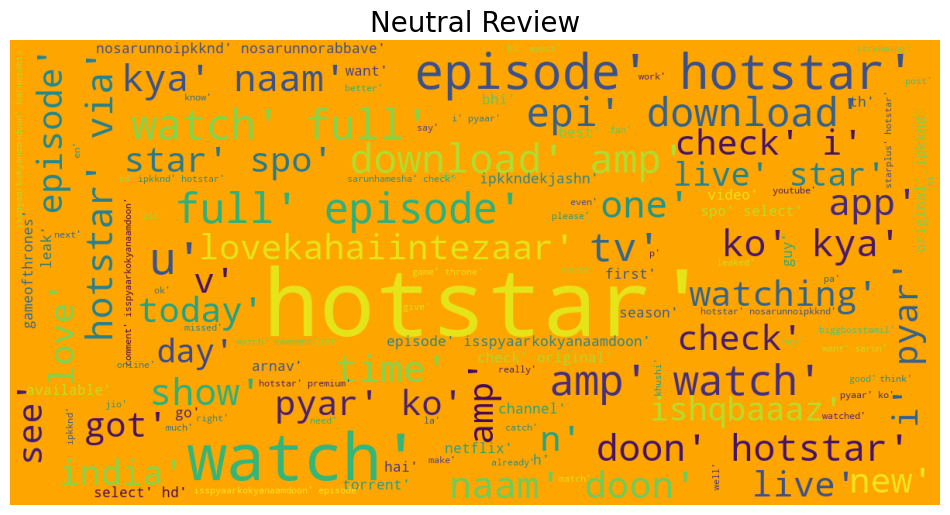

In [76]:
fig= plt.figure(1,figsize=(12,12))
plt.axis('off')
plt.imshow(word_cloud_ntrl)
plt.title("Neutral Review",size=20)
plt.show()

# Deep Learning approach

In [77]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras import Sequential

In [78]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [79]:
review_data1=review_data[['clean_review','Sentiment']]

In [80]:
review_data1.head()

,clean_review,Sentiment
0,hh,Negative
1,,Negative
2,paymnt premium subscription transaction failed...,Negative
3,currently jio network know whether able watch ...,Negative
4,episode sarabhai v sarabhai season downloadabl...,Negative


In [81]:
review_data1['Sentiment']=review_data1['Sentiment'].astype('category')
review_data1['Sentiment']=review_data1['Sentiment'].cat.codes
review_data1['Sentiment'].value_counts()

Sentiment
1    1738
2    1733
0    1582
Name: count, dtype: int64

In [82]:
x=review_data1.iloc[:,0:1]
y=review_data1.iloc[:,-1]

In [83]:
x.head()

,clean_review
0,hh
1,
2,paymnt premium subscription transaction failed...
3,currently jio network know whether able watch ...
4,episode sarabhai v sarabhai season downloadabl...


In [84]:
bow = CountVectorizer()
x_bow= bow.fit_transform(x['clean_review']).toarray()

In [85]:
x_bow1=pd.DataFrame(x_bow)

In [86]:
x_bow1.head()

,0,1,2,3,4,5,6,7,8,9,...,5565,5566,5567,5568,5569,5570,5571,5572,5573,5574
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Sentiment, dtype: int8

In [88]:
x_bow1.shape,y.shape

((5053, 5575), (5053,))

In [90]:
model=Sequential()
model.add(Dense(128,activation='relu',input_dim=5575))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.fit(x_bow1,y,epochs=100,batch_size=32,validation_split=0.2)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5016 - loss: 0.9650 - val_accuracy: 0.5173 - val_loss: 2.0343
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8842 - loss: 0.3336 - val_accuracy: 0.5183 - val_loss: 2.4034
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9460 - loss: 0.1716 - val_accuracy: 0.5559 - val_loss: 2.6335
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9684 - loss: 0.0958 - val_accuracy: 0.5272 - val_loss: 3.0793
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9728 - loss: 0.0749 - val_accuracy: 0.5054 - val_loss: 3.7394
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9789 - loss: 0.0592 - val_accuracy: 0.4857 - val_loss: 4.0619
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9783 - loss: 0.0598 - val_accuracy: 0.5312 - val_loss: 3.8807
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9830 - loss: 0.0526 - 